<a href="https://colab.research.google.com/github/Anuj-1996/Deep_Learning_for_Hidden_Market_Regimes_VAE_-_Transformer_Extension_to-LGMM/blob/main/Deep_Learning_for_Hidden_Market_Regimes_VAE_%26_Transformer_Extension_to%C2%A0LGMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: imports and environment setup
# What this does: import required libraries and set plotting styles
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix
from sklearn.metrics.cluster import contingency_matrix
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid', context='talk')


In [2]:
# Cell 2: Download SPY daily data using yfinance
# What this does: fetches SPY price history and computes log returns
symbol = 'SPY'
start = '2005-01-01'
end = datetime.today().strftime('%Y-%m-%d')

df = yf.download(symbol, start=start, end=end, progress=False)
df = df[('Close', 'SPY')].to_frame(name='close') # Extract 'Close' and rename to 'close'
df['logret'] = np.log(df['close']).diff() # Calculate log returns using the 'close' column
df.dropna(inplace=True)
df.reset_index(inplace=True) # Reset index to make 'Date' a column
df.rename(columns={'index': 'Date'}, inplace=True) # Rename the index column to 'Date'
print(df.head())

        Date      close    logret
0 2005-01-04  80.846985 -0.012295
1 2005-01-05  80.289093 -0.006925
2 2005-01-06  80.697304  0.005071
3 2005-01-07  80.581650 -0.001434
4 2005-01-10  80.962662  0.004717


In [3]:
# Cell 3: Feature engineering - rolling vol, momentum, returns
# What this does: creates rolling volatility, momentum, and returns as features
window_vol = 21  # ~1 month trading days
window_mom = 5   # short momentum

df['ret_1d'] = df['logret']
df['vol_21d'] = df['logret'].rolling(window_vol).std() * np.sqrt(252)  # annualized vol proxy
df['mom_5d'] = df['close'].pct_change(window_mom)
df.dropna(inplace=True)

features = df[['ret_1d', 'vol_21d', 'mom_5d']].copy()
print(features)


        ret_1d   vol_21d    mom_5d
20    0.003023  0.100447  0.017401
21   -0.002603  0.091181  0.013029
22    0.010619  0.094462  0.023844
23   -0.001331  0.093488  0.016165
24    0.001165  0.093214  0.010933
...        ...       ...       ...
5226  0.015228  0.126790 -0.012760
5227 -0.001222  0.125707 -0.010297
5228  0.004430  0.126381 -0.011796
5229 -0.006834  0.128815 -0.015674
5230  0.005660  0.129293  0.017411

[5211 rows x 3 columns]


Why these features?


*   ret_1d captures immediate returns.
*   vol_21d captures market uncertainty (regimes often defined by volatility).

* mom_5d short-term trend; momentum vs mean-revert regimes can be separated here.

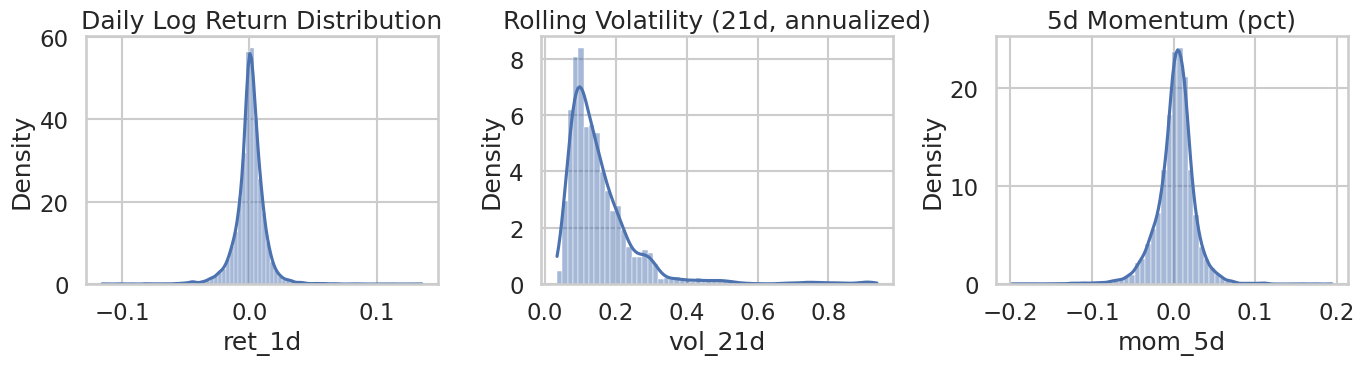

In [4]:
# Cell 4: Plot histograms and density plots for features
# What this does: visualizes marginal distributions for returns and vol
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
sns.histplot(features['ret_1d'], kde=True, stat='density', bins=80)
plt.title('Daily Log Return Distribution')

plt.subplot(1,3,2)
sns.histplot(features['vol_21d'], kde=True, stat='density', bins=60)
plt.title('Rolling Volatility (21d, annualized)')

plt.subplot(1,3,3)
sns.histplot(features['mom_5d'].dropna(), kde=True, stat='density', bins=60)
plt.title('5d Momentum (pct)')
plt.tight_layout()
plt.show()


Interpretation:

* Returns: heavy tails and skewness — not Gaussian.

* Volatility: skewed, long right tail — crisis spikes.

* Momentum: symmetric-ish but depends on regime.

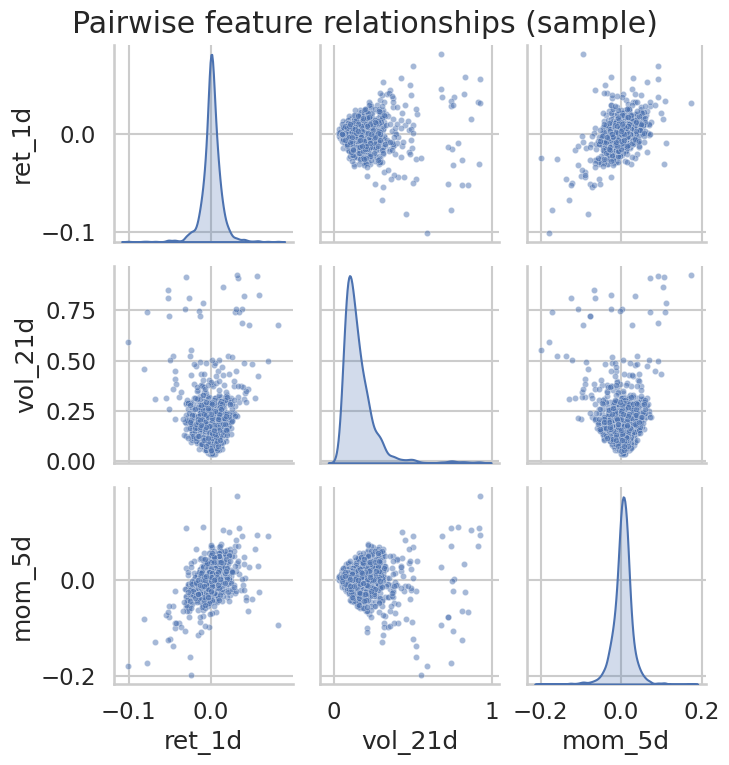

Correlation matrix:
            ret_1d   vol_21d    mom_5d
ret_1d   1.000000 -0.007986  0.423119
vol_21d -0.007986  1.000000 -0.056426
mom_5d   0.423119 -0.056426  1.000000


In [5]:
# Cell 5: Scatter and correlation plots between features
# What this does: shows pairwise relationships between features
sns.pairplot(features.sample(2000), diag_kind='kde', plot_kws={'alpha':0.5, 's':20})
plt.suptitle('Pairwise feature relationships (sample)', y=1.02)
plt.show()

print("Correlation matrix:\n", features.corr())


Interpretation:
* Volatility and returns often weakly negatively correlated - spikes in vol accompany negative returns.
* Momentum versus returns: depends on lookback.

*Feature scaling note:* We'll need to scale features before feeding models. LGMM can work on raw features but scaling makes clusters comparable. VAE and Transformer greatly benefit from standardized inputs.

### c LGMM Regime Clustering

In [6]:
# Cell 6: Prepare scaled features for clustering
# What this does: standardizes features for all models
scaler = StandardScaler()
X = scaler.fit_transform(features.values)
dates = features.index


In [7]:
# Cell 7: Fit Gaussian Mixture (LGMM) and assign regimes
# What this does: fits GaussianMixture with n_components and labels each day
n_clusters = 3
gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=42)
gmm.fit(X)
lgmm_labels = gmm.predict(X)


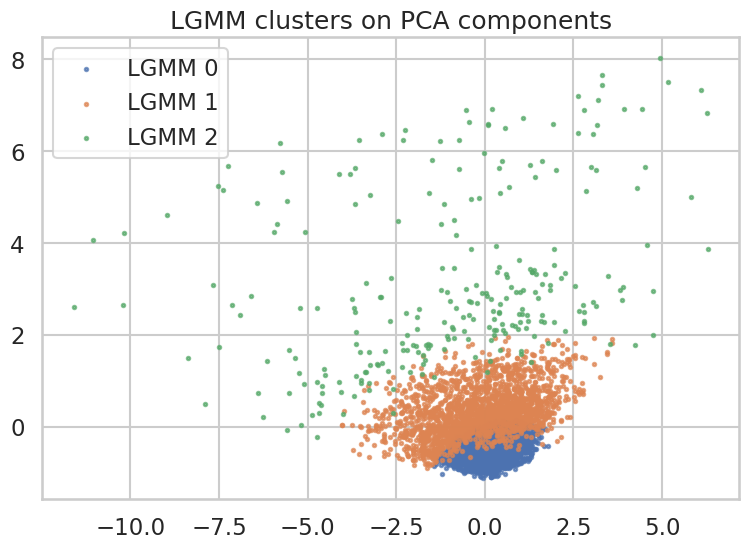

In [8]:
# Cell 8: Visualize LGMM clusters on PCA-projected 2D space
# What this does: projects features to 2D (PCA) and plots points colored by LGMM cluster
pca = PCA(n_components=2)
Xp = pca.fit_transform(X)
plt.figure(figsize=(9,6))
for k in range(n_clusters):
    plt.scatter(Xp[lgmm_labels==k,0], Xp[lgmm_labels==k,1], s=6, alpha=0.7, label=f'LGMM {k}')
plt.title('LGMM clusters on PCA components')
plt.legend()
plt.show()


Interpretation:
* Each LGMM cluster typically corresponds to regimes: a low-vol, small-return cluster; a moderate cluster; and a high-vol, large-negative-return cluster (crisis).
* Inspect cluster statistics for meaning:

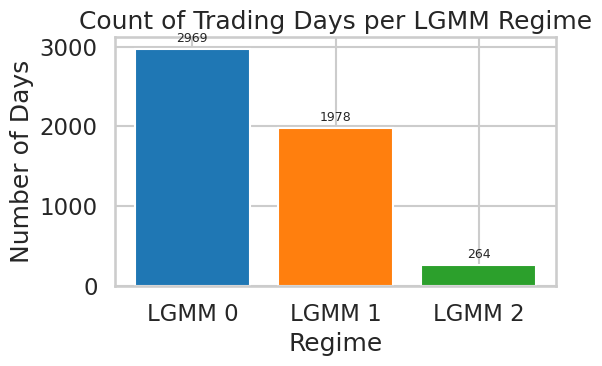

In [10]:
# Count days in each regime
counts = [np.sum(lgmm_labels == k) for k in range(n_clusters)]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # same as default matplotlib scatter colors

plt.figure(figsize=(6,4))
bars = plt.bar(
    range(n_clusters),
    counts,
    tick_label=[f'LGMM {k}' for k in range(n_clusters)],
    color=colors
)

# Add value labels above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 50,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.title('Count of Trading Days per LGMM Regime')
plt.xlabel('Regime')
plt.ylabel('Number of Days')
plt.tight_layout()
plt.show()

In [11]:
# Cell 9: Summarize cluster statistics in original feature space
# What this does: prints mean and std of features per LGMM cluster for interpretation
df_lgmm = features.copy()
df_lgmm['lgmm'] = lgmm_labels
print(df_lgmm.groupby('lgmm').agg(['mean','std']).T)


lgmm                 0         1         2
ret_1d  mean  0.000979  0.000009 -0.003098
        std   0.005179  0.012877  0.036290
vol_21d mean  0.099596  0.196553  0.512515
        std   0.027444  0.053748  0.198117
mom_5d  mean  0.005942 -0.000984 -0.013567
        std   0.010978  0.027237  0.064227


What this tells you:

* Cluster with highest vol_21d.mean usually is crisis.

* Cluster with positive mom_5d.mean and lower vol likely trend/stable.

### d. Variational Autoencoder (VAE) Latent Modeling

In [23]:
# Cell 10: Build and train a simple VAE in PyTorch
# What this does: defines VAE architecture and training loop
import random
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Fix random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Make sure CUDA behaves deterministically (optional, but helps)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
dataset = TensorDataset(X_tensor)
loader = DataLoader(dataset, batch_size=256, shuffle=True, drop_last=False)

latent_dim = 2
input_dim = X.shape[1]
hidden_dim = 16
lr = 1e-3
epochs = 300

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, input_dim)
        self.act = nn.ReLU()
    def encode(self, x):
        h = self.act(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    def decode(self, z):
        h = self.act(self.fc_decode(z))
        return self.fc_out(h)
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

model = VAE(input_dim, hidden_dim, latent_dim).to(device)
opt = torch.optim.Adam(model.parameters(), lr=lr)


In [24]:
# Cell 11: VAE training loop
# What this does: trains the VAE with reconstruction + KL loss
def loss_fn(recon, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon, x, reduction='sum')
    # KL divergence between posterior q(z|x) and N(0,1)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl

model.train()
for ep in range(epochs):
    total_loss = 0.0
    for batch in loader:
        x_batch = batch[0]
        opt.zero_grad()
        recon, mu, logvar = model(x_batch)
        loss = loss_fn(recon, x_batch, mu, logvar)
        loss.backward()
        opt.step()
        total_loss += loss.item()
    if (ep+1) % 10 == 0:
        print(f'Epoch {ep+1}/{epochs} - loss: {total_loss/len(X):.4f}')


Epoch 10/300 - loss: 2.6296
Epoch 20/300 - loss: 2.2530
Epoch 30/300 - loss: 2.1825
Epoch 40/300 - loss: 2.1806
Epoch 50/300 - loss: 2.1408
Epoch 60/300 - loss: 2.1273
Epoch 70/300 - loss: 2.0970
Epoch 80/300 - loss: 2.0866
Epoch 90/300 - loss: 2.1022
Epoch 100/300 - loss: 2.0698
Epoch 110/300 - loss: 2.0320
Epoch 120/300 - loss: 2.0673
Epoch 130/300 - loss: 2.0408
Epoch 140/300 - loss: 2.0277
Epoch 150/300 - loss: 2.0270
Epoch 160/300 - loss: 2.0111
Epoch 170/300 - loss: 2.0454
Epoch 180/300 - loss: 2.0172
Epoch 190/300 - loss: 2.0025
Epoch 200/300 - loss: 1.9970
Epoch 210/300 - loss: 2.0026
Epoch 220/300 - loss: 1.9859
Epoch 230/300 - loss: 1.9837
Epoch 240/300 - loss: 1.9687
Epoch 250/300 - loss: 1.9683
Epoch 260/300 - loss: 1.9746
Epoch 270/300 - loss: 1.9829
Epoch 280/300 - loss: 1.9888
Epoch 290/300 - loss: 1.9704
Epoch 300/300 - loss: 1.9688


In [25]:
# Cell 12: Get latent codes for all points and KMeans cluster them
# What this does: encodes data into 2D latent space and clusters with KMeans
model.eval()
with torch.no_grad():
    mu, logvar = model.encode(X_tensor)
    z = mu.cpu().numpy()  # use mean as deterministic code

kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(z)
vae_labels = kmeans.labels_


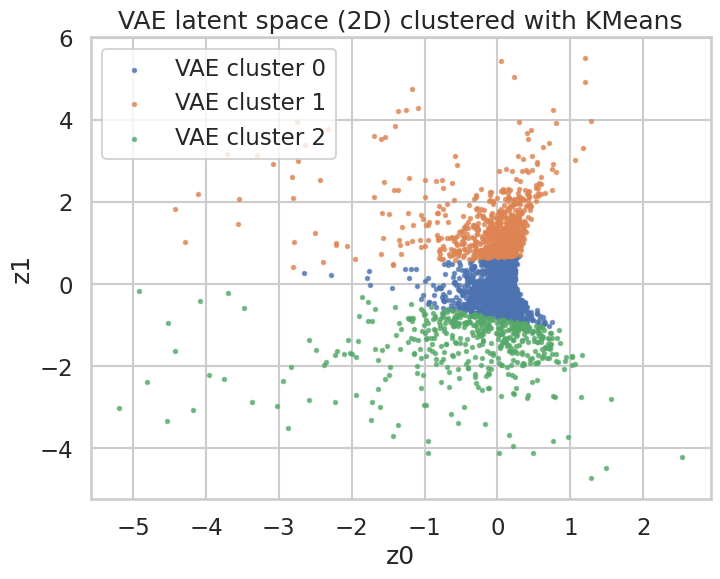

In [26]:
# Cell 13: Plot VAE latent space colored by KMeans cluster
# What this does: plots 2D latent points and colors by VAE KMeans cluster
plt.figure(figsize=(8,6))
for k in range(n_clusters):
    plt.scatter(z[vae_labels==k,0], z[vae_labels==k,1], s=6, alpha=0.7, label=f'VAE cluster {k}')
plt.title('VAE latent space (2D) clustered with KMeans')
plt.legend()
plt.xlabel('z0'); plt.ylabel('z1')
plt.show()


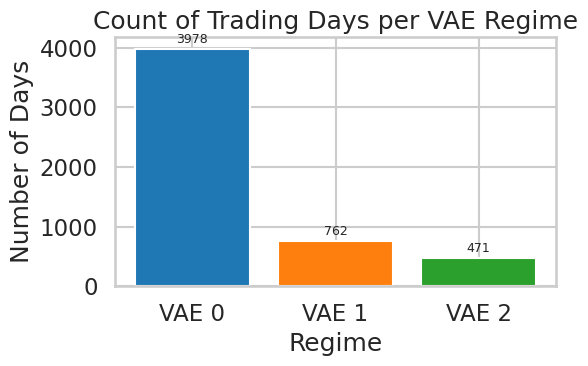

In [27]:
# Histogram of VAE regime counts
plt.figure(figsize=(6,4))
counts_vae = [np.sum(vae_labels == k) for k in range(n_clusters)]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # same as before

bars = plt.bar(
    range(n_clusters),
    counts_vae,
    tick_label=[f'VAE {k}' for k in range(n_clusters)],
    color=colors
)

# Add value labels above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 50,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.title('Count of Trading Days per VAE Regime')
plt.xlabel('Regime')
plt.ylabel('Number of Days')
plt.tight_layout()
plt.show()


In [17]:
# Cell 14: Compare cluster stats for VAE clusters
# What this does: aggregate original features per VAE cluster for interpretation
df_vae = features.copy()
df_vae['vae'] = vae_labels
print(df_vae.groupby('vae').agg(['mean','std']).T)


vae                  0         1         2
ret_1d  mean  0.001292 -0.016442  0.013626
        std   0.005999  0.014055  0.014939
vol_21d mean  0.120471  0.218168  0.299948
        std   0.052105  0.132659  0.171663
mom_5d  mean  0.004780 -0.032714  0.026381
        std   0.013122  0.026559  0.028860


### e. Transformer Encoder for Sequence Modeling

In [28]:
# Cell 15: Create sequences for Transformer (rolling windows)
# What this does: constructs rolling overlapping sequences for each time t
seq_len = 16  # number of timesteps per sample
step = 1
X_seq = []
y_seq = []
for i in range(seq_len, len(X)):
    seq = X[i-seq_len:i]  # shape seq_len x feat_dim
    X_seq.append(seq)
    y_seq.append(vae_labels[i])  # target: VAE cluster for last day
X_seq = np.stack(X_seq)
y_seq = np.array(y_seq)
print("Sequences:", X_seq.shape, "Targets:", y_seq.shape)


Sequences: (5195, 16, 3) Targets: (5195,)


In [29]:
# Cell 16: Transformer encoder model in PyTorch
# What this does: defines a small Transformer encoder and classifier head
class TransEnc(nn.Module):
    def __init__(self, feat_dim, d_model=32, nhead=8, num_layers=4, dim_feedforward=64, n_classes=3):
        super().__init__()
        self.input_proj = nn.Linear(feat_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model//2),
            nn.ReLU(),
            nn.Linear(d_model//2, n_classes)
        )
    def forward(self, x):  # x: batch x seq_len x feat_dim
        x = self.input_proj(x)  # -> batch x seq_len x d_model
        x = x.permute(1,0,2)    # transformer expects seq_len x batch x d_model
        out = self.transformer(x)  # seq_len x batch x d_model
        last = out[-1,:,:]  # take last timestep representation
        logits = self.classifier(last)
        return logits

# prepare data loaders
batch_size = 128
X_seq_t = torch.tensor(X_seq, dtype=torch.float32)
y_seq_t = torch.tensor(y_seq, dtype=torch.long)
dataset_seq = TensorDataset(X_seq_t, y_seq_t)
loader_seq = DataLoader(dataset_seq, batch_size=batch_size, shuffle=True)

# model + training
model_t = TransEnc(feat_dim=X.shape[1], n_classes=n_clusters).to(device)
opt_t = torch.optim.Adam(model_t.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
epochs_t = 300


In [30]:
# Cell 17: Train Transformer encoder classifier to predict VAE clusters (self-supervised)
# What this does: trains transformer to predict regime labels derived from VAE
model_t.train()
for ep in range(epochs_t):
    total_loss = 0.0
    total_acc = 0.0
    for xb, yb in loader_seq:
        xb = xb.to(device); yb = yb.to(device)
        opt_t.zero_grad()
        logits = model_t(xb)
        loss = criterion(logits, yb)
        loss.backward()
        opt_t.step()
        total_loss += loss.item() * xb.size(0)
        total_acc += (logits.argmax(1) == yb).sum().item()
    if (ep+1) % 5 == 0:
        print(f'Epoch {ep+1}/{epochs_t} - loss {total_loss/len(dataset_seq):.4f} acc {total_acc/len(dataset_seq):.3f}')


Epoch 5/300 - loss 0.4652 acc 0.803
Epoch 10/300 - loss 0.4589 acc 0.808
Epoch 15/300 - loss 0.4538 acc 0.814
Epoch 20/300 - loss 0.4522 acc 0.808
Epoch 25/300 - loss 0.4433 acc 0.817
Epoch 30/300 - loss 0.4387 acc 0.816
Epoch 35/300 - loss 0.4349 acc 0.815
Epoch 40/300 - loss 0.4368 acc 0.818
Epoch 45/300 - loss 0.4171 acc 0.826
Epoch 50/300 - loss 0.4097 acc 0.833
Epoch 55/300 - loss 0.4037 acc 0.831
Epoch 60/300 - loss 0.3946 acc 0.834
Epoch 65/300 - loss 0.3882 acc 0.840
Epoch 70/300 - loss 0.3757 acc 0.849
Epoch 75/300 - loss 0.3672 acc 0.849
Epoch 80/300 - loss 0.3577 acc 0.854
Epoch 85/300 - loss 0.3513 acc 0.854
Epoch 90/300 - loss 0.3436 acc 0.857
Epoch 95/300 - loss 0.3301 acc 0.864
Epoch 100/300 - loss 0.3328 acc 0.865
Epoch 105/300 - loss 0.3116 acc 0.871
Epoch 110/300 - loss 0.3183 acc 0.870
Epoch 115/300 - loss 0.3070 acc 0.873
Epoch 120/300 - loss 0.2972 acc 0.882
Epoch 125/300 - loss 0.2969 acc 0.882
Epoch 130/300 - loss 0.2797 acc 0.887
Epoch 135/300 - loss 0.2931 acc 

In [31]:
# Cell 18: Get transformer predicted clusters for the timeline
# What this does: runs the transformer on sequences and collects predicted labels aligned with dates
model_t.eval()
with torch.no_grad():
    logits = model_t(X_seq_t.to(device))
    t_labels = logits.argmax(1).cpu().numpy()

# Align to full date index (first seq_len days will be NaN)
t_dates = dates[seq_len:]


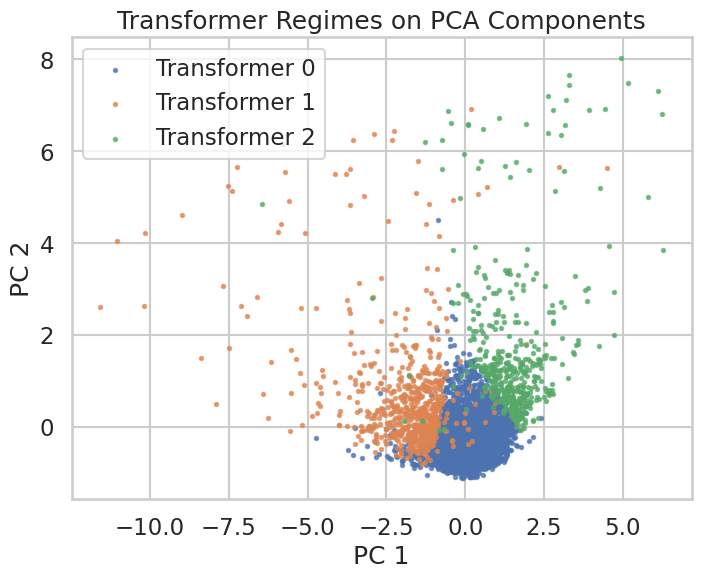

In [33]:
#  Plot Transformer predicted clusters on PCA-projected 2D space
# What this does: projects features corresponding to sequences to 2D (PCA) and plots points colored by Transformer cluster

# Align Xp to the length of y_seq (and t_labels)
# Xp corresponds to the full dataset, y_seq/t_labels start seq_len days in
Xp_aligned = Xp[seq_len:]

plt.figure(figsize=(8,6))
# Use Xp_aligned and t_labels (Transformer predictions) for plotting
for k in range(n_clusters):
    # Plot Xp_aligned points colored by Transformer labels (t_labels)
    plt.scatter(Xp_aligned[t_labels == k, 0], Xp_aligned[t_labels == k, 1], s=6, alpha=0.7, label=f'Transformer {k}')

plt.title('Transformer Regimes on PCA Components')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend()
plt.show()

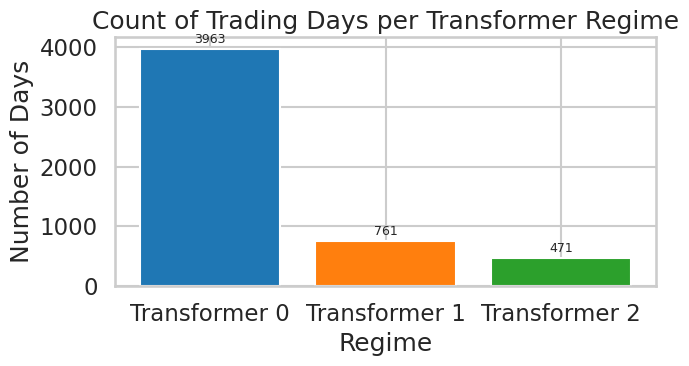

In [35]:
plt.figure(figsize=(7,4))
counts_t = [np.sum(y_seq == k) for k in range(n_clusters)]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # keep same palette for consistency

bars = plt.bar(
    range(n_clusters),
    counts_t,
    tick_label=[f'Transformer {k}' for k in range(n_clusters)],
    color=colors
)

# Add count labels above bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 50,
        f'{int(height)}',
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.title('Count of Trading Days per Transformer Regime')
plt.xlabel('Regime')
plt.ylabel('Number of Days')
plt.tight_layout()
plt.show()

### f. Regime Label Comparison and Temporal Plots

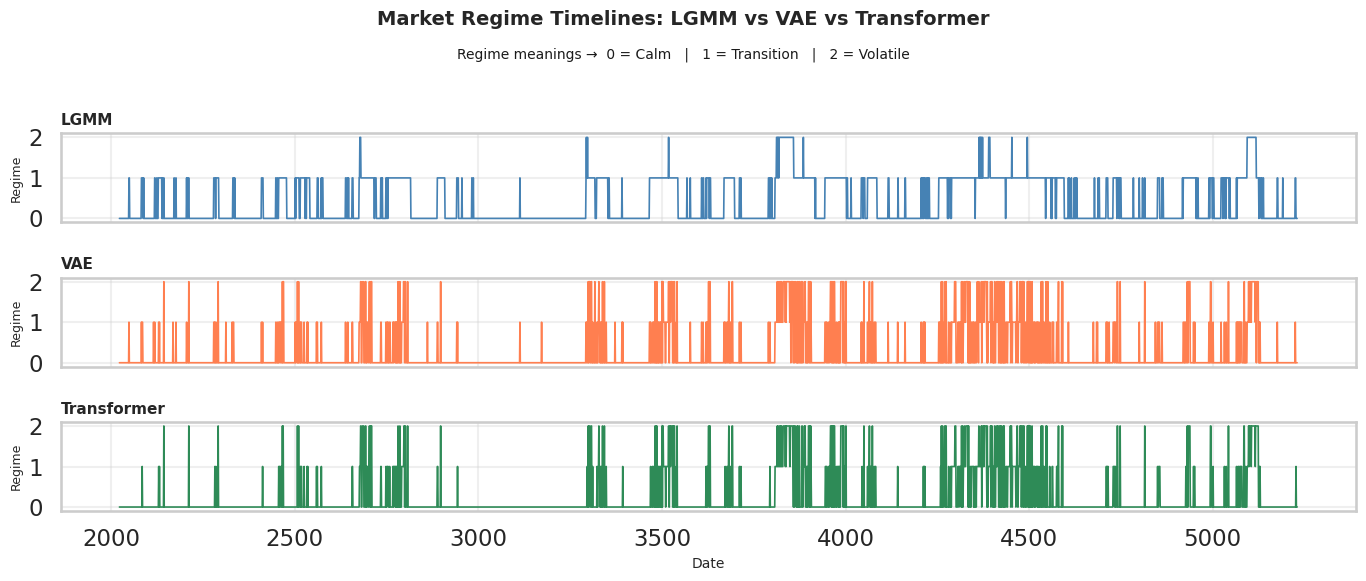

In [36]:
# Cell 19: Plot regime timeline (LGMM, VAE, Transformer) over time
# What this does: constructs a DataFrame with labels and plots regimes as stacked areas
label_df = pd.DataFrame(index=dates)
label_df['lgmm'] = lgmm_labels
label_df['vae'] = vae_labels
# align transformer (shorter)
label_df['transformer'] = np.nan
label_df.loc[t_dates, 'transformer'] = t_labels

# Plot regime timeline for a sample period (last 3 years for clarity)
# --- Build dataframe ---
label_df = pd.DataFrame(index=dates)
label_df['LGMM'] = lgmm_labels
label_df['VAE'] = vae_labels
label_df['Transformer'] = np.nan
label_df.loc[t_dates, 'Transformer'] = t_labels

# --- Focus on recent period ---
start_plot = '2021-01-01'
dfp = label_df.loc[start_plot:]

# --- Plot ---
fig, axes = plt.subplots(3, 1, figsize=(14, 6), sharex=True)
models = ['LGMM', 'VAE', 'Transformer']
colors = ['steelblue', 'coral', 'seagreen']

for ax, model, color in zip(axes, models, colors):
    ax.plot(dfp.index, dfp[model], color=color, lw=1.2)
    ax.set_title(model, loc='left', fontsize=11, fontweight='bold')
    ax.set_yticks([0, 1, 2])
    ax.set_ylabel('Regime', fontsize=9)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Date', fontsize=10)

# --- Overall title and annotation ---
fig.suptitle('Market Regime Timelines: LGMM vs VAE vs Transformer', fontsize=14, fontweight='bold')

# Add text below title explaining regime meanings
fig.text(0.5, 0.9, 'Regime meanings →  0 = Calm   |   1 = Transition   |   2 = Volatile',
         ha='center', fontsize=10, color='k')

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

In [37]:
# Cell 20: Quantify transition frequency
# What this does: counts number of regime changes per model per year

def transitions(series):
    """Count how many times a regime changes (NaNs ignored)."""
    s = series.dropna().astype(int)
    return (s.shift(1) != s).sum()

# compute transitions dynamically for all regime columns
models = ['LGMM','VAE','Transformer'] # Use uppercase names
transition_counts = {m: transitions(label_df[m]) for m in models}

# print results
for name, total in transition_counts.items():
    print(f'{name}: total transitions (all data) = {total}')

LGMM: total transitions (all data) = 533
VAE: total transitions (all data) = 1230
Transformer: total transitions (all data) = 1023


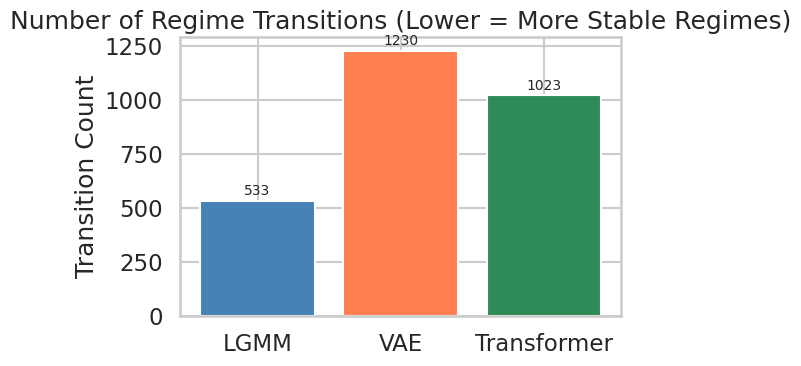

In [38]:
# plot results
plt.figure(figsize=(6,4))
plt.bar(transition_counts.keys(), transition_counts.values(),
        color=['steelblue','coral','seagreen'])
plt.title('Number of Regime Transitions (Lower = More Stable Regimes)')
plt.ylabel('Transition Count')

# annotate bar values
for i, v in enumerate(transition_counts.values()):
    plt.text(i, v + (max(transition_counts.values()) * 0.02), str(v),
             ha='center', fontsize=10)

plt.tight_layout()
plt.show()

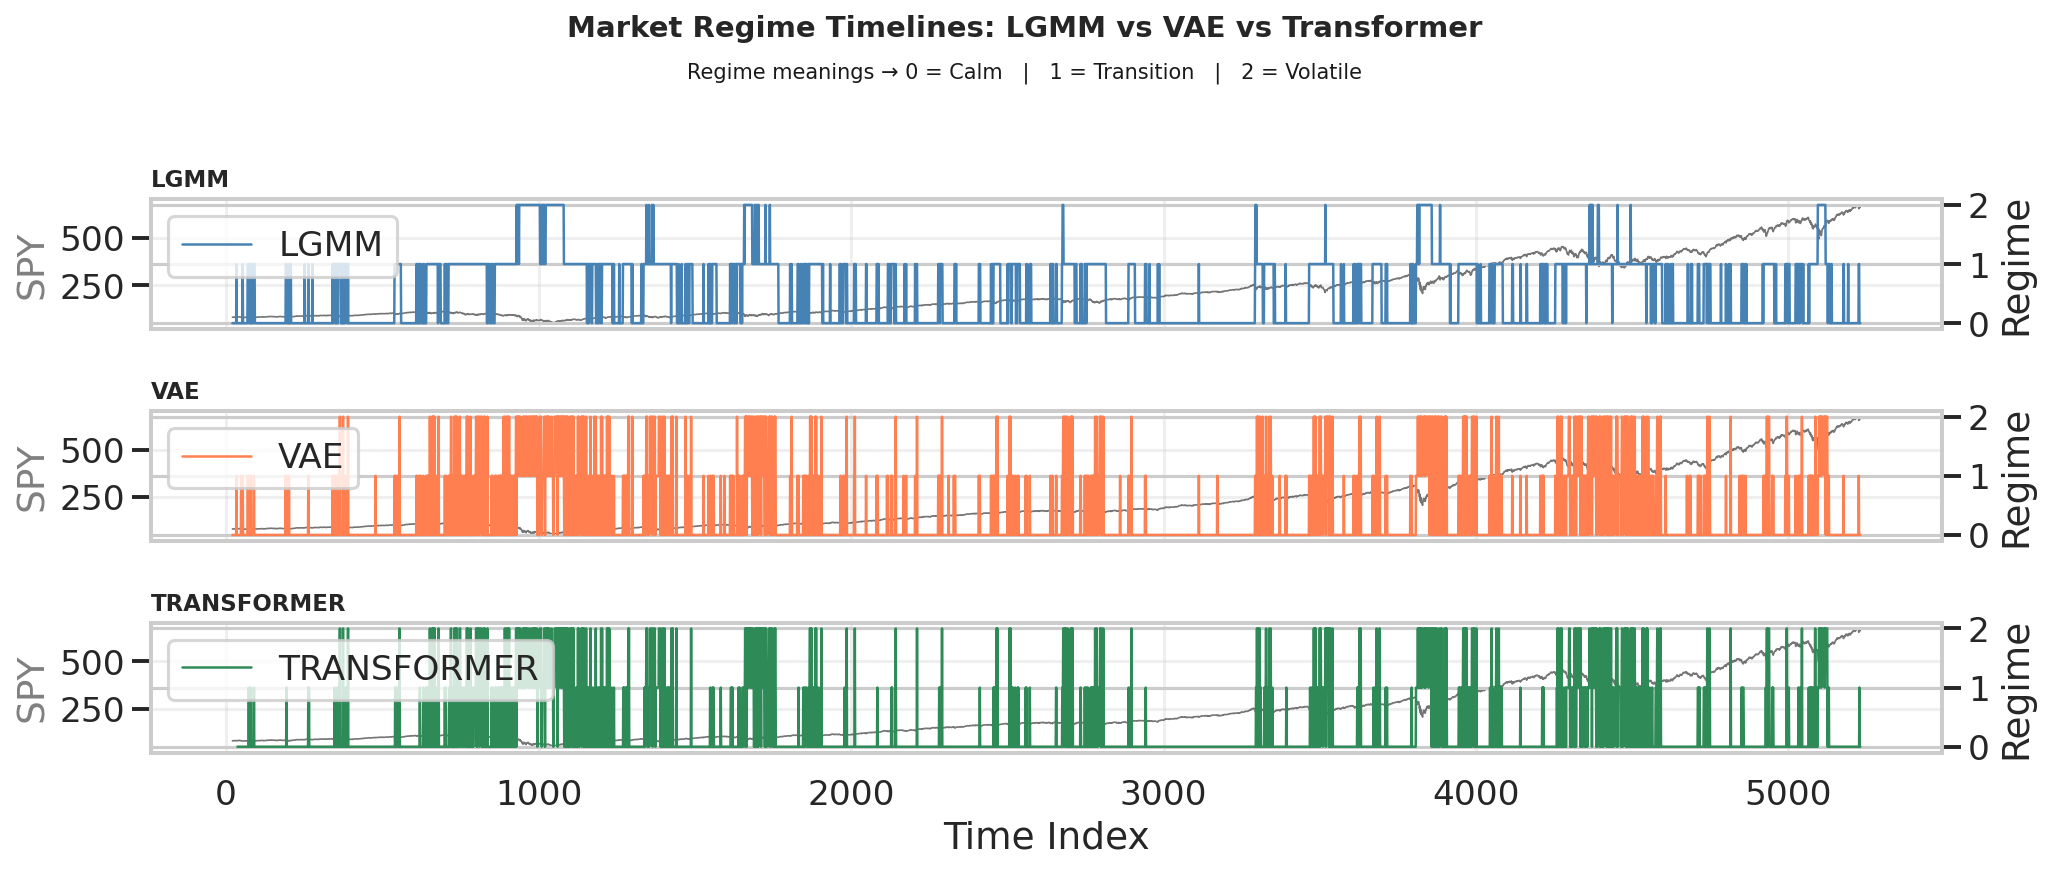

In [39]:
# ============================================================
# FINAL SUMMARY SECTION
# ============================================================
# what this does:
#  - plots price vs regime timeline
#  - compares regime transition counts
#  - shows regime persistence (transition matrix)
#  - summarizes avg return / volatility per regime with legend outside
# ============================================================

sns.set(style='whitegrid', context='talk')
plt.rcParams.update({'figure.dpi': 150})

# --- sanity check ---
assert 'close' in df.columns, "df['close'] missing"
assert 'logret' in df.columns, "df['logret'] missing"

# --- align labels ---
label_df = label_df.copy()
label_df.columns = [c.lower() for c in label_df.columns]

# ============================================================
# 1. PRICE VS REGIME TIMELINE
# ============================================================
# --- Regime timeline comparison with subplots (clean version) ---
import matplotlib.pyplot as plt

models = ['lgmm', 'vae', 'transformer']
colors = ['steelblue', 'coral', 'seagreen']

fig, axes = plt.subplots(3, 1, figsize=(14, 6), sharex=True)

for ax, model, color in zip(axes, models, colors):
    ax.plot(df['close'], color='k', lw=0.8, alpha=0.6)
    ax2 = ax.twinx()
    ax2.plot(label_df[model], color=color, lw=1.2, label=model.upper())
    ax.set_ylabel('SPY', color='gray')
    ax2.set_ylabel('Regime')
    ax2.set_yticks([0,1,2])
    ax2.legend(loc='upper left')
    ax.set_title(model.upper(), loc='left', fontsize=11, fontweight='bold')
    ax.grid(alpha=0.3)

axes[-1].set_xlabel('Time Index')
fig.suptitle('Market Regime Timelines: LGMM vs VAE vs Transformer', fontsize=14, weight='bold')
fig.text(0.5, 0.91, 'Regime meanings → 0 = Calm   |   1 = Transition   |   2 = Volatile',
         ha='center', fontsize=10, color='k')

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()





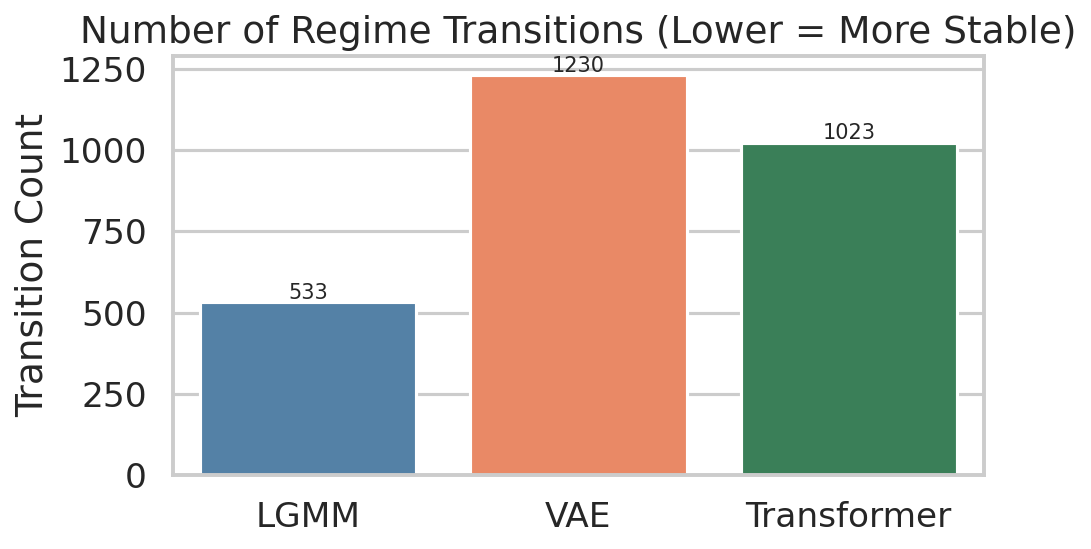

In [40]:
# ============================================================
# 2. REGIME TRANSITION FREQUENCY
# ============================================================
def count_transitions(series):
    s = pd.Series(series).dropna().astype(int)
    return (s.shift(1) != s).sum()

transitions = {
    'LGMM': count_transitions(label_df['lgmm']),
    'VAE': count_transitions(label_df['vae']),
    'Transformer': count_transitions(label_df['transformer'])
}

plt.figure(figsize=(7,4))
sns.barplot(x=list(transitions.keys()), y=list(transitions.values()),
            palette=['steelblue','coral','seagreen'])
plt.title('Number of Regime Transitions (Lower = More Stable)')
plt.ylabel('Transition Count')
for i, v in enumerate(transitions.values()):
    plt.text(i, v + 10, str(v), ha='center', fontsize=10)
plt.tight_layout()
plt.show()



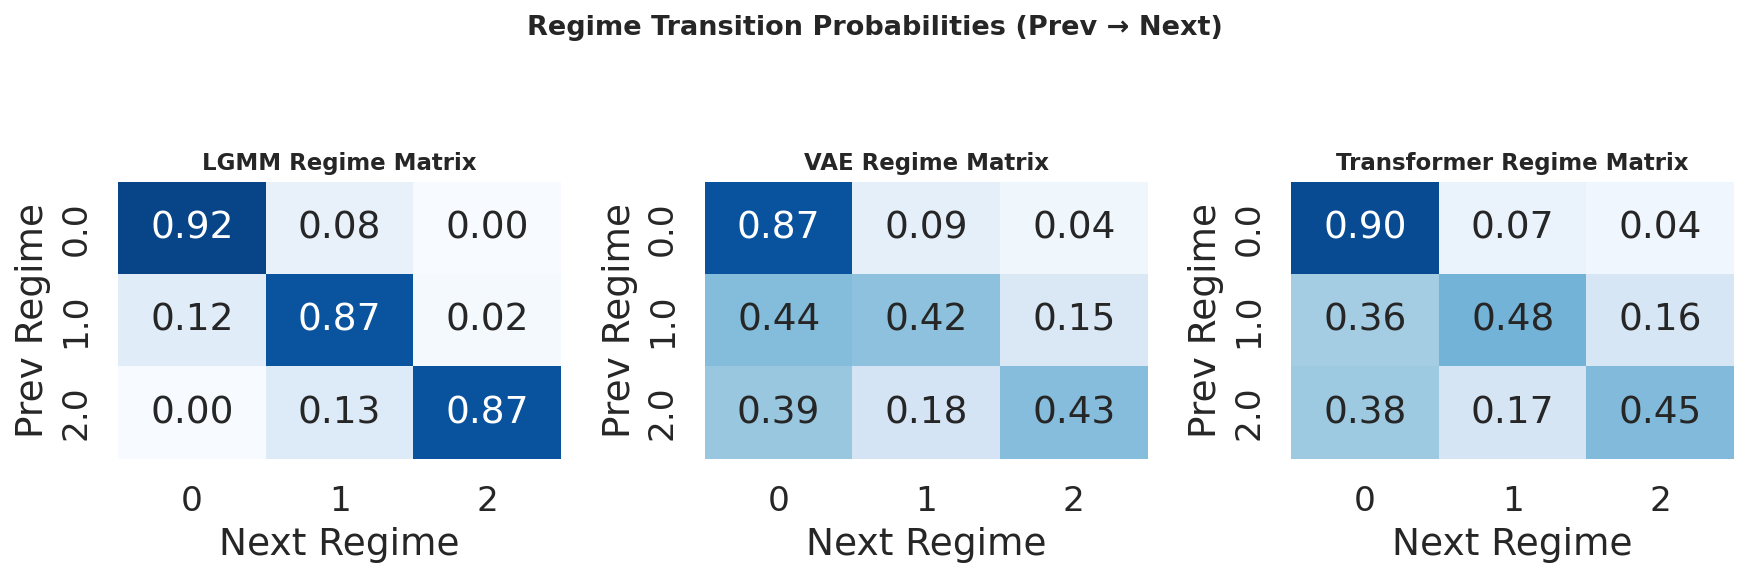

In [41]:
# ============================================================
# 3. REGIME TRANSITION MATRIX (PERSISTENCE)
# ============================================================

def transition_matrix(labels):
    """Compute normalized transition matrix (prev → next regime)."""
    s = pd.Series(labels).dropna().astype(int)
    return pd.crosstab(s.shift(1), s, normalize='index')

models = ['lgmm', 'vae', 'transformer']
titles = ['LGMM', 'VAE', 'Transformer']
colors = ['steelblue', 'coral', 'seagreen']

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# keep a consistent color scale across all heatmaps
vmin, vmax = 0, 1

for ax, model, title, color in zip(axes, models, titles, colors):
    mat = transition_matrix(label_df[model])
    sns.heatmap(mat, annot=True, cmap='Blues', fmt='.2f',
                cbar=False, vmin=vmin, vmax=vmax, ax=ax)
    ax.set_title(f'{title} Regime Matrix', fontsize=11, fontweight='bold')
    ax.set_xlabel('Next Regime')
    ax.set_ylabel('Prev Regime')

fig.suptitle('Regime Transition Probabilities (Prev → Next)', fontsize=13, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()



         Model  Regime  AnnReturn  AnnVol  Sharpe
0         LGMM     0.0      0.247   0.082   2.999
1         LGMM     1.0      0.002   0.204   0.011
2         LGMM     2.0     -0.781   0.576  -1.355
3          VAE     0.0      3.134   0.276  11.362
4          VAE     1.0      0.539   0.101   5.351
5          VAE     2.0     -4.177   0.214 -19.496
6  TRANSFORMER     0.0      3.011   0.289  10.436
7  TRANSFORMER     1.0      0.412   0.111   3.699
8  TRANSFORMER     2.0     -3.658   0.239 -15.280


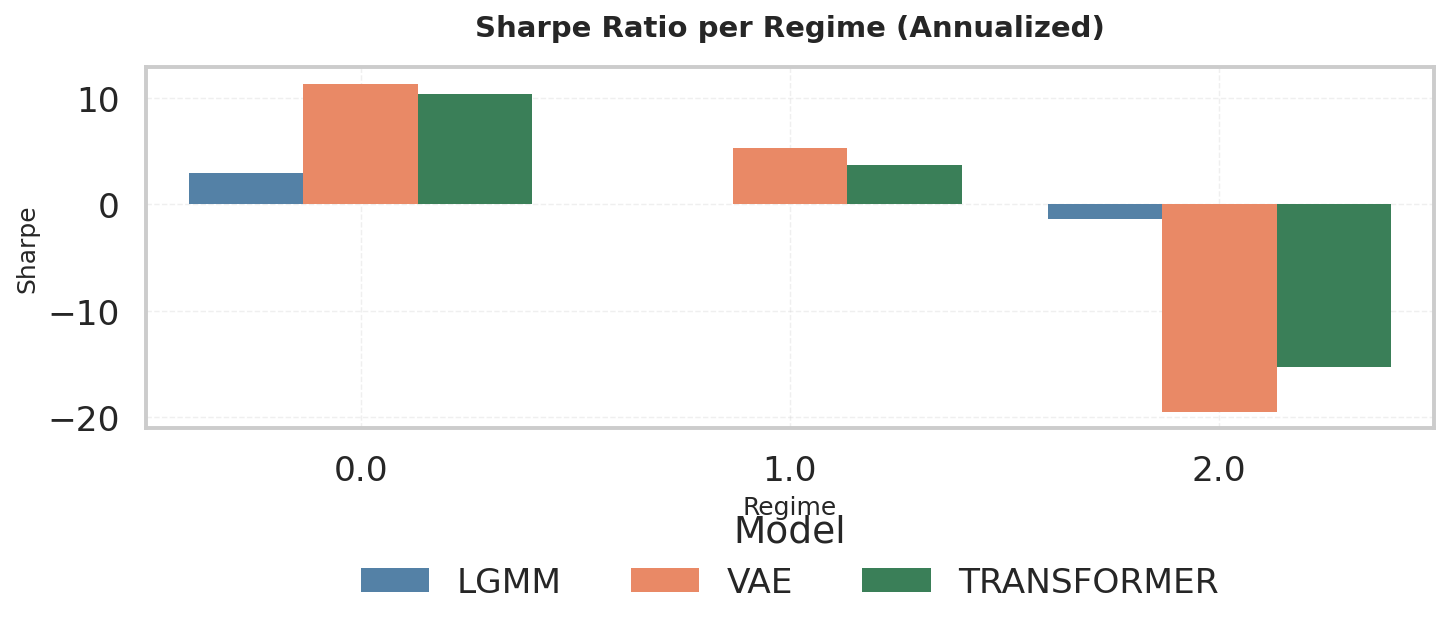

In [114]:
# ============================================================
# 4. FEATURE PROFILE PER REGIME
# ============================================================
summary = []
for model in ['lgmm','vae','transformer']:
    lbl = label_df[model]
    tmp = pd.concat([df[['logret']], lbl.rename('regime')], axis=1)
    for r in sorted(lbl.dropna().unique()):
        sub = tmp.loc[tmp['regime']==r, 'logret']
        summary.append([
            model.upper(), r,
            sub.mean()*252,                   # annualized return
            sub.std()*np.sqrt(252),           # annualized vol
            (sub.mean()/sub.std())*np.sqrt(252) if sub.std()!=0 else np.nan  # Sharpe
        ])
summary_df = pd.DataFrame(summary, columns=['Model','Regime','AnnReturn','AnnVol','Sharpe'])
print(summary_df.round(3))

# --- Sharpe Ratio per Regime ---
sns.set(style='whitegrid', context='talk')
plt.rcParams.update({'figure.dpi': 150})

plt.figure(figsize=(10, 5))  # wider layout
ax = sns.barplot(
    data=summary_df,
    x='Regime', y='Sharpe', hue='Model',
    palette=['steelblue', 'coral', 'seagreen'],
    edgecolor='none'
)

ax.set_title('Sharpe Ratio per Regime (Annualized)', fontsize=14, fontweight='bold', pad=15)
ax.set_ylabel('Sharpe', fontsize=12)
ax.set_xlabel('Regime', fontsize=12)
ax.grid(alpha=0.3, linestyle='--', linewidth=0.7)

# move legend below for balance
plt.legend(
    title='Model',
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=3,
    frameon=False
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
